<a href="https://www.kaggle.com/code/ambujsingh11294/cdac-project?scriptVersionId=197263604" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Tuberculosis Classification using Xception** 
---
### **Overview of Tuberculosis (TB)**

**According to [World Health Organization (WHO)](https://www.who.int/health-topics/tuberculosis#tab=tab_1)**
* Tuberculosis is caused by bacteria (Mycobacterium tuberculosis) and it most often affects the lungs. TB is spread through the air when people with lung TB cough, sneeze or spit. A person needs to inhale only a few germs to become infected.
* If we look at chest X-ray of a person with advanced tuberculosis, we will see **infection in lungs** and **the formation of a cavity**.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWfVD5iIMNyJdAYNMayyhK6q3WbfBxynoH_w&usqp=CAU)



Image reference : [radlines.org](https://radlines.org/X-ray_of_the_thorax_in_tuberculosis)


## **Use these links to jump to specific sections of this notebook**
- [1. EDA and splitting data](#1)
    - [Load images and metadata](#1-1)
    - [Split data for train val and test dataset](#1-2)
    - [Display sample images from training dataset](#1-3)
        - [Normal X-ray images](#1-3-1)
        - [Tuberculosis X-ray images](#1-3-2)
- [2. Preprocessing data](#2)
    - [Build a train generator](#2-1)
    - [Build validation and test generators](#2-2)
    - [Display a normalized image in train generator](#2-3)
- [3. Handling class imbalance](#3)
- [4. Transfer learning with Xception](#4)
    - [Model summary](#4-1)
- [5. Model evaluation](#5)
    - [Classification report](#5-1)
    - [Confusion matrix](#5-2)
    - [ROC AUC](#5-3)
- [6. Grad-cam evaluation](#6)
    - [Example of Grad-cam overlay on Tuberculosis](#6-1)


---
<a id='1'></a>
# **EDA and splitting data**

In [12]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [13]:
tf.__version__

'2.6.4'

In [14]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Load and prep image function
def load_and_prep_image(filename, img_shape=224, scale=True):
    """Reads in an image from filename, turns it into a tensor and reshapes into (img_shape, img_shape, 3)."""
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img / 255.0
    else:
        return img

# Make confusion matrix function
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels."""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # number of classes

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix", xlabel="Predicted label", ylabel="True label",
           xticks=np.arange(n_classes), yticks=np.arange(n_classes),
           xticklabels=labels, yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)", horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black", size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black", size=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

# Plot loss curves function
def plot_loss_curves(history):
    """Plots separate loss curves for training and validation metrics."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    """Creates a TensorBoard callback to store log files."""
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
def pred_and_plot(model, filename, class_names):
    """Loads an image, makes a prediction using a model, and plots the image with its predicted class."""
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()]
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
def compare_historys(original_history, new_history, initial_epochs=5):
    """Compares two model history objects and plots accuracy and loss."""
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.show()
import zipfile

def unzip_data(filename):
    """Unzips a file into the current working directory."""
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()


<a id='1-1'></a>
### **Load images and metadata**

In [15]:
# load metadata
df_norm = pd.read_excel('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [16]:
# Example of metadata
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [17]:
# Join both normal and tuberculosis excels
# create Label feature ['Tuberculosis']
# Add 'Tuberculosis' column
df_norm['Tuberculosis'] = np.float(0)
df_tb['Tuberculosis'] = np.float(1)

# Columns to be dropped
columns_to_drop = ['FORMAT', 'SIZE', 'URL']

# Drop columns if they exist in df_norm
df_norm.drop(columns=[col for col in columns_to_drop if col in df_norm.columns], inplace=True)

# Drop columns if they exist in df_tb
df_tb.drop(columns=[col for col in columns_to_drop if col in df_tb.columns], inplace=True)

# Concatenate dataframes
df = pd.concat([df_norm, df_tb])

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())

          FILE NAME  Tuberculosis
0       Normal-2827           0.0
1  Tuberculosis-443           1.0
2  Tuberculosis-315           1.0
3         Normal-50           0.0
4       Normal-3154           0.0


In [18]:
# Rename column
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [19]:
# Walk through directory
# Define the function to walk through the directory
def walk_through_dir(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

# Set the dataset path
ds = "../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

# Walk through the directory
walk_through_dir(ds)

# Define the source paths
SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')

# List the files in the directories
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in ../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database.
There are 0 directories and 700 images in ../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.
There are 0 directories and 3500 images in ../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [20]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
    train_dir = os.path.join(root_path,'training')
    val_dir = os.path.join(root_path, 'validation')
    test_dir = os.path.join(root_path,'testing')
    os.makedirs(train_dir + '/Normal', exist_ok=True)
    os.makedirs(train_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(val_dir + '/Normal', exist_ok=True)
    os.makedirs(val_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(test_dir + '/Normal', exist_ok=True)
    os.makedirs(test_dir + '/Tuberculosis', exist_ok=True)
    os.makedirs(root_path + '/Images', exist_ok=True)

create_img_train_val_test_dirs('./')


In [21]:
# Map train validation test directories

IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

<a id='1-2'></a>
### **Split data for train val and test dataset**
#### Partition as {train : 80, Val : 10, Test : 10}
#### Equally split for both Normal and Tuberculosis

In [22]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')
    
  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

    
split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [23]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [24]:
len(os.listdir(IMAGE_DIR))

4200

In [25]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [26]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [27]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [28]:
# If we create dfs correctly, the sum of rows should be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


<a id='1-3'></a>
### **Display sample images from training dataset**

In [29]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

In [30]:
train_norm[:5]

['./training/Normal/Normal-3130.png',
 './training/Normal/Normal-1509.png',
 './training/Normal/Normal-1070.png',
 './training/Normal/Normal-1926.png',
 './training/Normal/Normal-2191.png']

<a id='1-3-1'></a>
### **Normal X-ray images**

Normal


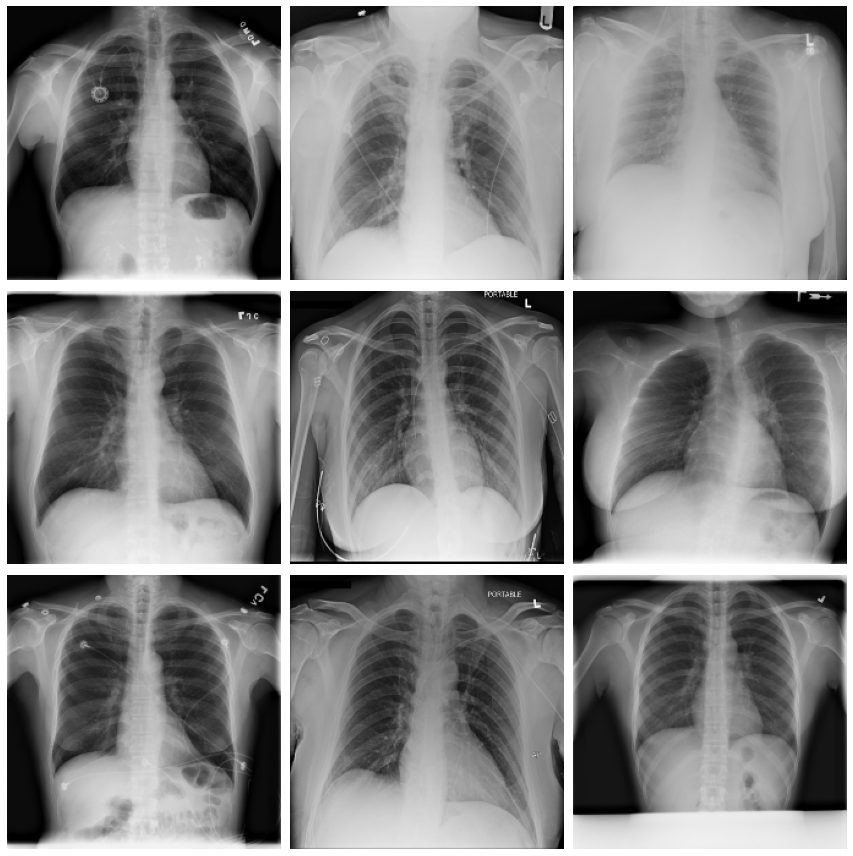

In [31]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

<a id='1-3-2'></a>
### **Tuberculosis X-ray images**

Tuberculosis


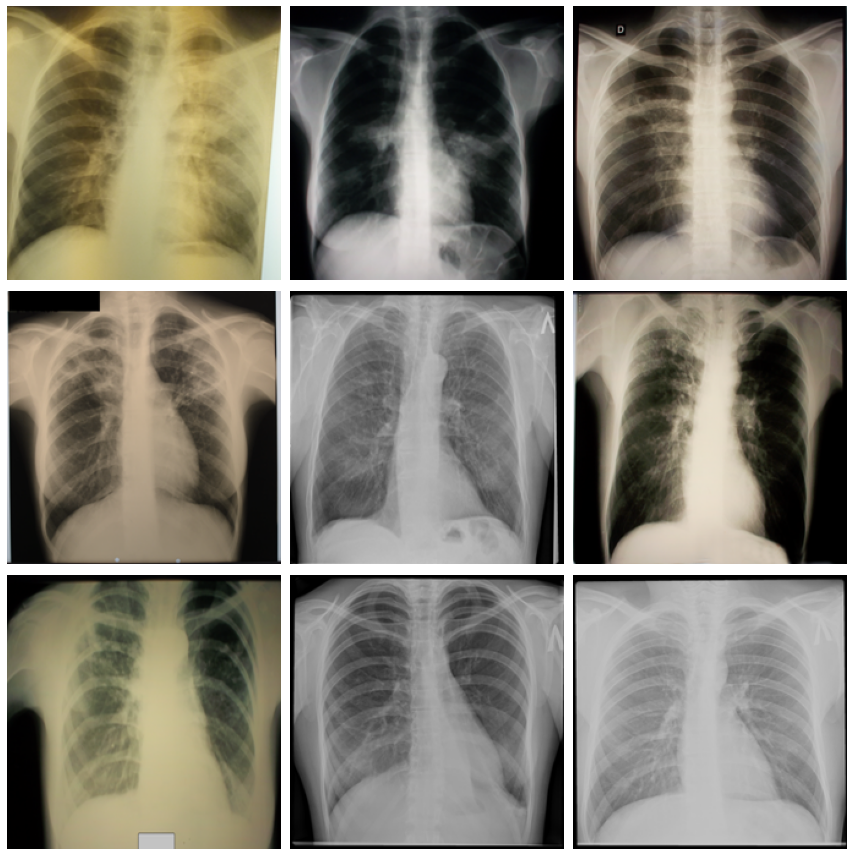

In [32]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

<a id='2'></a>
# **Preprocessing data**

<a id='2-1'></a>
## **Build a train generator**
### **few things to note:** 
1. We **normalize** the mean and standard deviation of **each data**
2. We **shuffle** the input after each epoch.
3. We set the image size to be **320px by 320px**
4. We apply some **aumentations (Rotation, Zoom, Width shift and Height shift)** based on possition deviation which could possibly be slightly changed when radiographers x-ray patients
5. The generator converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels. (The pre-trained model requires three-channel inputs)

In [33]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.
    
    print("getting train generator...") 
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
   
    return train_generator

<a id='2-2'></a>
## **Build validation and test generators**
### **few things to note:**
1. We normalize validation data and incoming test data using the **statistics computed from the training set**
2. For reduce time consuming, we'll take a random sample of the dataset and calculate the sample mean and sample standard deviation. (Ideally, we should compute our sample mean and standard deviation using the entire training set)

In [34]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    # This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return val_generator, test_generator

In [35]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3360 validated image filenames.
getting val and test generators...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


<a id='2-3'></a>
### **Display a normalized image in train generator**

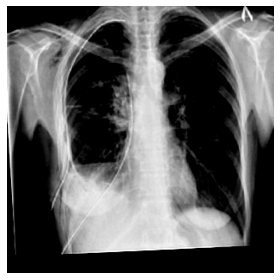

Image shape (320, 320, 3)


In [36]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

<a id='3'></a>
# **Handling class imbalance** 
### Fixed by Sample Weighting in Loss Function (weighting the contributions of positive and negative losses to be equal)
#### More information cae be read [here](https://www.kaggle.com/code/sanphats/microcalcification-weighting-loss-dnn)



In [37]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [38]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

create positive/negative contributors
$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$
$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

In [39]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Final weight loss
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [40]:
# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

<a id='4'></a>
# **Transfer learning with Xception**

In [41]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Set the path where the weights are stored

weights_path = "/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Verify the path
assert os.path.exists(weights_path), "Weights file not found!"



# Use Xception instead of DenseNet121
base_model = Xception(weights=weights_path, include_top=False, input_shape=(320, 320, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a logistic layer for binary classification
output = Dense(1, activation="sigmoid")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy", "AUC"])



In [42]:
# Callbacks
checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# ModelCheckpoint callback to save model after every epoch
MC = ModelCheckpoint(filepath=checkpoint_path, verbose=2, save_weights_only=True)

# Optional: ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
# RLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=2, min_lr=0.001)

# Optional: EarlyStopping to stop training when a monitored metric has stopped improving
# ES = EarlyStopping(monitor='val_loss', patience=4, verbose=2)



In [43]:
# Fit model with the training and validation generators, using the callbacks
history = model.fit_generator(
    train_generator, 
    validation_data=val_generator,
    steps_per_epoch=100, 
    validation_steps=30,  
    epochs=3,
    callbacks=[MC]
)

Epoch 1/3
100/100 [==============================] - 39s 281ms/step - loss: 0.2020 - accuracy: 0.9287 - auc: 0.9479 - val_loss: 0.1208 - val_accuracy: 0.9875 - val_auc: 0.9865

Epoch 00001: saving model to ./training_1/cp.ckpt
Epoch 2/3
100/100 [==============================] - 27s 264ms/step - loss: 0.0411 - accuracy: 0.9850 - auc: 0.9982 - val_loss: 0.4513 - val_accuracy: 0.9083 - val_auc: 0.9189

Epoch 00002: saving model to ./training_1/cp.ckpt
Epoch 3/3
100/100 [==============================] - 27s 265ms/step - loss: 0.1128 - accuracy: 0.9700 - auc: 0.9766 - val_loss: 0.0734 - val_accuracy: 0.9917 - val_auc: 0.9861

Epoch 00003: saving model to ./training_1/cp.ckpt


In [44]:
# load weights
model = Model(inputs=base_model.input, outputs = output)
model.load_weights(checkpoint_path)

<a id='4-1'></a>
### **Model summary**

In [45]:
#model.summary()
#number_layer = len(model.layers)
#print(number_layer)

<a id='5'></a>
# **Model evaluation**

In [46]:
#### Information and codes can be found here [AI in Medical diagnosis course](https://www.coursera.org/learn/ai-for-medical-diagnosis)
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


random.seed(a=None, version=2)
set_verbosity(INFO)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

<a id='5-1'></a>
## **Classification report**

In [47]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
#print(predicted_vals)
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()
#print(predicted_vals)

In [48]:
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       350
         1.0       1.00      0.84      0.91        70

    accuracy                           0.97       420
   macro avg       0.98      0.92      0.95       420
weighted avg       0.97      0.97      0.97       420

Accuracy of the Model: 97.38095238095238 %


In [49]:
# save predictions to csv file

y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

<a id='5-2'></a>
## **Confusion matrix**

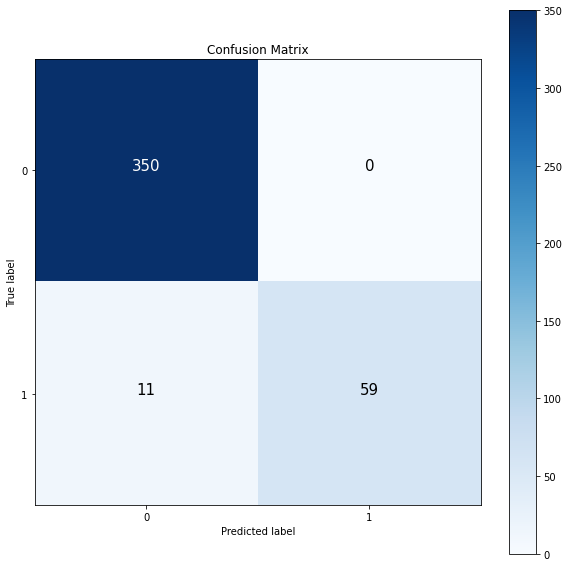

In [50]:
import itertools
make_confusion_matrix(y_test, y_pred)

<a id='5-3'></a>
## **ROC AUC**

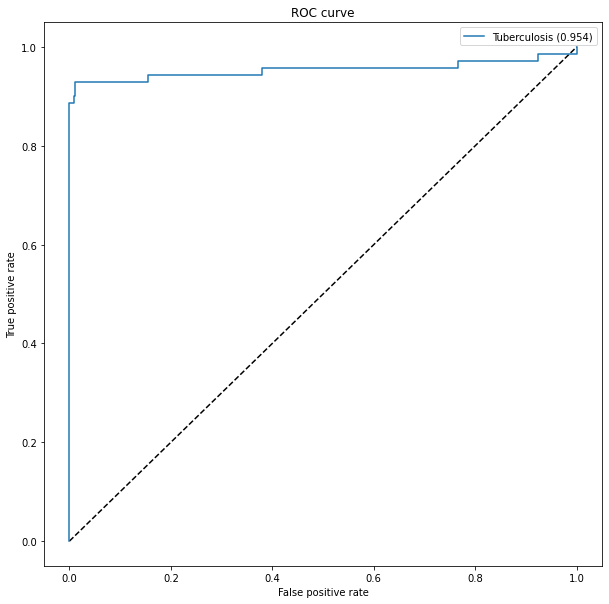

In [51]:
labels = ['Tuberculosis']
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

<a id='6'></a>
# **Grad-cam evaluation**

#### Information of Gradient-weighted Class Activation Mapping (Grad-CAM) can be found here [Cornell University](https://arxiv.org/abs/1610.02391)
#### Codes are inspired by [stackoverflow](https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network)

In [52]:
# Normalization using batch statistics
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(50)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
    return x


In [53]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [54]:
# Sample 50 images for Batch normalization
imgs_path = []
for fn in test_df['Image'][:50]:
    full_path = IMAGE_DIR + '/' + fn
    imgs_path.append(full_path)

In [55]:
# Normalize with mean and std of batchs
test = [load_image(i, IMAGE_DIR, test_df ) for i in imgs_path]

In [56]:
# convert to numpy array
test = np.array(test)
print(test.shape)

(50, 320, 320, 3)


In [57]:
# Find the sample image that is predicted as Tuberculosis 
preds = model.predict(test)
preds_ = np.where(preds > 0.5,1,0)
pos_pred = np.where(preds_.flatten() == 1)
n = pos_pred[0][0]
n

7

In [58]:
# Now we know which images were predicted as Tuberculosis from preds_
# create img_test which is predicted Tuberculosis
img_test = np.expand_dims(test[n], axis = 0)
preds = model.predict(img_test) 
i = np.where(preds > 0.5,1,0)

# Verify if prediction == 1
i.flatten()

array([1])

In [59]:
# Create the original image path of img_test

img_path = imgs_path[n]

In [60]:
icam = GradCAM(model, i, 'block14_sepconv2') 
heatmap = icam.compute_heatmap(img_test)
heatmap = cv2.resize(heatmap, (320, 320))

image = cv2.imread(img_path)
image = cv2.resize(image, (320, 320))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(320, 320) (320, 320, 3)


<a id='6-1'></a>
## **Example of Grad-cam overlay on Tuberculosis**

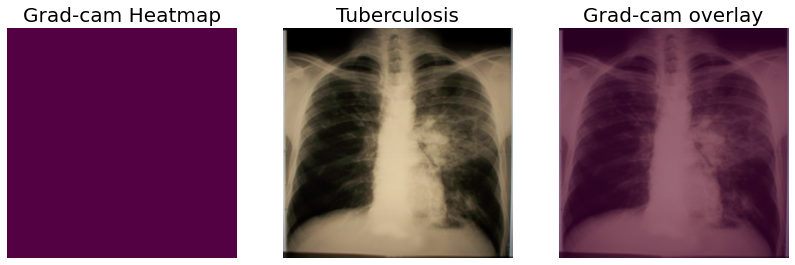

In [61]:
fig, ax = plt.subplots(1, 3, figsize = (14,14))

ax[0].imshow(heatmap)
ax[0].axis('Off')
ax[0].set_title('Grad-cam Heatmap', fontsize = 20)
ax[1].imshow(image)
ax[1].axis('Off')
ax[1].set_title('Tuberculosis', fontsize = 20)
ax[2].imshow(output)
ax[2].axis('Off')
ax[2].set_title('Grad-cam overlay', fontsize = 20)
fig.show()